In [79]:
import pandas as pd
import numpy as np
from sklearn import cluster
from sklearn import mixture
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import discriminant_analysis
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder

from sklearn.decomposition import PCA
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import pickle

import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
import numpy as np

In [80]:
bd = pd.read_csv('./NNData_87.csv')
sd = pd.read_csv('./cfb22_nn_w1_w9.csv')

In [81]:
sd = sd.dropna(axis=0)

In [82]:
bd_target = bd[['home_team_cover_spread']]
sd_target = sd[['home_team_cover_spread']]

In [83]:
bd = bd.drop(['Unnamed: 0','index'], axis=1)
sd = sd.drop(['Unnamed: 0'], axis=1)

In [84]:
bd = bd.drop(['year','home_team_cover_spread', 'home_conference_ACC', 'home_conference_American Athletic',
       'home_conference_Big 12', 'home_conference_Big Ten',
       'home_conference_Conference USA', 'home_conference_FBS Independents',
       'home_conference_Mid-American', 'home_conference_Mountain West',
       'home_conference_Pac-12', 'home_conference_SEC',
       'home_conference_Sun Belt', 'away_conference_ACC',
       'away_conference_American Athletic', 'away_conference_Big 12',
       'away_conference_Big Ten', 'away_conference_Conference USA',
       'away_conference_FBS Independents', 'away_conference_Mid-American',
       'away_conference_Mountain West', 'away_conference_Pac-12',
       'away_conference_SEC', 'away_conference_Sun Belt', 'neutral_site_False',
       'neutral_site_True'], axis = 1)

In [85]:
sd = sd.drop(['home_team_cover_spread', 'home_conference_ACC','week', 'home_conference_American Athletic',
       'home_conference_Big 12', 'home_conference_Big Ten',
       'home_conference_Conference USA', 'home_conference_FBS Independents',
       'home_conference_Mid-American', 'home_conference_Mountain West',
       'home_conference_Pac-12', 'home_conference_SEC',
       'home_conference_Sun Belt', 'away_conference_ACC',
       'away_conference_American Athletic', 'away_conference_Big 12',
       'away_conference_Big Ten', 'away_conference_Conference USA',
       'away_conference_FBS Independents', 'away_conference_Mid-American',
       'away_conference_Mountain West', 'away_conference_Pac-12',
       'away_conference_SEC', 'away_conference_Sun Belt', 'neutral_site_False',
       'neutral_site_True'],axis=1)

In [86]:
sd.columns

Index(['home_elo', 'away_elo', 'spread', 'h_drives', 'h_d_explosiveness',
       'h_d_successrate', 'h_d_stuffrate', 'h_d_totalPPA', 'h_o_explosiveness',
       'h_o_successrate', 'h_o_stuffrate', 'h_o_totalPPA'],
      dtype='object')

In [87]:
bdX = bd.copy()
sdX = sd.copy()

## For ffs we utilize RidgeCV to measure info gain of variables to selcet the next best next variable

In [88]:
ridge = linear_model.RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(bdX, bd_target)
sfs1 = sfs(ridge, k_features=10, forward=True, verbose=0, scoring='neg_mean_squared_error')

In [89]:
sfs1 = sfs1.fit(bdX, bd_target)

In [90]:
feat_names = list(sfs1.k_feature_names_)
print("FFS BD Features:")
feat_names

FFS BD Features:


['home_sp_plus',
 'away_sp_plus',
 'away_o_standardDowns',
 'd_successrate',
 'd_stuffrate',
 'd_totalPPA',
 'o_successrate',
 'o_stuffrate',
 'o_totalPPA',
 'spread']

In [91]:
bd_ffs = bd[feat_names]
bd_ffs

,home_sp_plus,away_sp_plus,away_o_standardDowns,d_successrate,d_stuffrate,d_totalPPA,o_successrate,o_stuffrate,o_totalPPA,spread
0,0.269394,0.253879,0.348936,0.320731,0.414815,0.548258,0.476062,0.777778,0.375059,0.358140
1,0.535966,0.770099,0.787234,0.426421,0.253968,0.453420,0.508663,0.283688,0.429014,0.483721
2,0.444288,0.627645,0.414894,0.389066,0.323232,0.580727,0.492695,0.555556,0.419397,0.706977
3,0.465444,0.640339,0.891489,0.356850,0.677249,0.414961,0.461988,0.487805,0.287224,0.353488
4,0.643159,0.765867,0.517021,0.416319,0.429119,0.343901,0.457086,0.416667,0.408007,0.488372
...,...,...,...,...,...,...,...,...,...,...
4739,0.854725,0.939351,0.547909,0.453735,0.263374,0.382001,0.580137,0.384615,0.619690,0.576744
4740,0.630465,0.736248,0.467021,0.423007,0.592593,0.432506,0.428511,0.294118,0.291695,0.548837
4741,0.648801,0.818054,0.494468,0.456522,0.213333,0.451703,0.237973,0.161290,0.254696,0.627907
4742,0.535966,0.479549,0.525902,0.369064,0.174863,0.492551,0.506460,0.333333,0.439154,0.474419


## FFS NN

In [92]:
trainx, testx, trainy, testy = train_test_split(bd_ffs, bd_target, test_size=.3, random_state=42)

In [93]:
bd_ffs_nn = mlrose.NeuralNetwork(hidden_nodes = [6,6], activation = 'relu', algorithm = 'gradient_descent', max_iters = 5000, bias = True, is_classifier = True, learning_rate = 0.0001,
early_stopping = True, clip_max = 5, max_attempts = 1000, random_state = 3)

In [94]:
bd_ffs_nn.fit(trainx,trainy)

NeuralNetwork(clip_max=5, early_stopping=True, hidden_nodes=[6, 6],
              learning_rate=0.0001, max_iters=5000)

In [95]:
y_train_pred = bd_ffs_nn.predict(trainx)

y_train_accuracy = accuracy_score(trainy, y_train_pred)

print('Training accuracy: ', y_train_accuracy)

# Predict labels for test set and assess accuracy
y_test_pred = bd_ffs_nn.predict(testx)

y_test_accuracy = accuracy_score(testy, y_test_pred)

print('Test accuracy: ', y_test_accuracy)

Training accuracy:  0.8156626506024096
Test accuracy:  0.8075842696629213


### Kmeans BD FFS

In [96]:
centers = []
inertia = []
for i in range(1,25):
    km = cluster.KMeans(n_clusters=i, random_state=0).fit(bd_ffs)
    centers.append(km.cluster_centers_)
    inertia.append(km.inertia_)

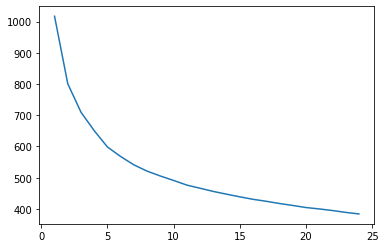

In [97]:
plt.plot(range(1,25),inertia)

In [98]:
kmeansbdffs = cluster.KMeans(n_clusters=7)
kmeansbdffs.fit(bd_ffs)
y_kmeans = kmeansbdffs.predict(bd_ffs)

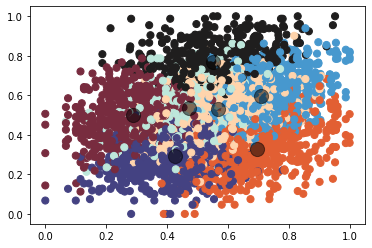

In [99]:
plt.scatter(bd_ffs.iloc[:, 0], bd_ffs.iloc[:, 1], c=y_kmeans, s=50, cmap='icefire')

centers = kmeansbdffs.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

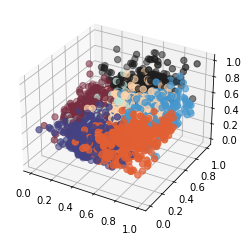

In [100]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(bd_ffs.iloc[:,0],bd_ffs.iloc[:,1],bd_ffs.iloc[:,2], c=y_kmeans, s=40, cmap='icefire')

## BD KM FFS NN

In [101]:
labels = kmeansbdffs.labels_
labels

array([2, 3, 0, ..., 3, 6, 0])

In [102]:
labelsdf = pd.DataFrame(labels, columns=["clusters"])
hot = OneHotEncoder().fit_transform(X = labelsdf).toarray()
labelsdf2 = pd.DataFrame(hot, columns= ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'])

In [103]:
bdkmffsnn_df = pd.concat([bd_ffs,labelsdf2], axis=1)
bdkmffsnn_df

,home_sp_plus,away_sp_plus,away_o_standardDowns,d_successrate,d_stuffrate,d_totalPPA,o_successrate,o_stuffrate,o_totalPPA,spread,C1,C2,C3,C4,C5,C6,C7
0,0.269394,0.253879,0.348936,0.320731,0.414815,0.548258,0.476062,0.777778,0.375059,0.358140,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.535966,0.770099,0.787234,0.426421,0.253968,0.453420,0.508663,0.283688,0.429014,0.483721,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.444288,0.627645,0.414894,0.389066,0.323232,0.580727,0.492695,0.555556,0.419397,0.706977,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.465444,0.640339,0.891489,0.356850,0.677249,0.414961,0.461988,0.487805,0.287224,0.353488,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.643159,0.765867,0.517021,0.416319,0.429119,0.343901,0.457086,0.416667,0.408007,0.488372,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4739,0.854725,0.939351,0.547909,0.453735,0.263374,0.382001,0.580137,0.384615,0.619690,0.576744,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4740,0.630465,0.736248,0.467021,0.423007,0.592593,0.432506,0.428511,0.294118,0.291695,0.548837,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4741,0.648801,0.818054,0.494468,0.456522,0.213333,0.451703,0.237973,0.161290,0.254696,0.627907,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4742,0.535966,0.479549,0.525902,0.369064,0.174863,0.492551,0.506460,0.333333,0.439154,0.474419,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [104]:
trainx, testx, trainy, testy = train_test_split(bdkmffsnn_df, bd_target, test_size=.3, random_state=42)

In [105]:
bd_km_ffs_nn = mlrose.NeuralNetwork(hidden_nodes = [6,6], activation = 'relu', algorithm = 'gradient_descent', max_iters = 5000, bias = True, is_classifier = True, learning_rate = 0.0001,
early_stopping = True, clip_max = 5, max_attempts = 1000, random_state = 3)

In [106]:
bd_km_ffs_nn.fit(trainx,trainy)

NeuralNetwork(clip_max=5, early_stopping=True, hidden_nodes=[6, 6],
              learning_rate=0.0001, max_iters=5000)

In [107]:
y_train_pred = bd_km_ffs_nn.predict(trainx)

y_train_accuracy = accuracy_score(trainy, y_train_pred)

print('Training accuracy: ', y_train_accuracy)

# Predict labels for test set and assess accuracy
y_test_pred = bd_km_ffs_nn.predict(testx)

y_test_accuracy = accuracy_score(testy, y_test_pred)

print('Test accuracy: ', y_test_accuracy)

Training accuracy:  0.8162650602409639
Test accuracy:  0.8146067415730337


### GMM BD FFS

In [108]:
# ~ 2 min
gmm_bic = []
gmm_aic = []
for i in range(1,25):
    gmm = mixture.GaussianMixture(n_components=i, random_state=0).fit(bd_ffs)
    gmm_bic.append(gmm.bic(bd_ffs))
    gmm_aic.append(gmm.aic(bd_ffs))

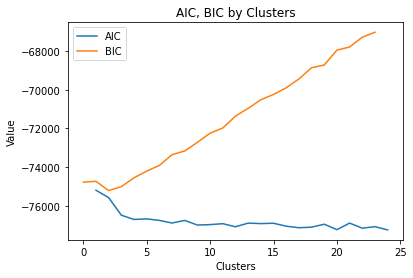

In [109]:
r = np.arange(1,25)
plt.plot(r, gmm_aic, gmm_bic)
plt.title("AIC, BIC by Clusters")
plt.xlabel('Clusters')
plt.ylabel('Value')
plt.legend(labels = ['AIC', 'BIC'])
plt.show()

In [110]:
# We will take AIC + BIC recommendation for simpler model and set K = 4
gmm = mixture.GaussianMixture(n_components=4).fit(bd_ffs)
labels = gmm.predict(bd_ffs)
print(gmm.converged_)

True


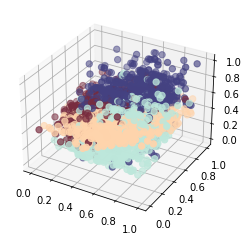

In [111]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(bd_ffs.iloc[:,0],bd_ffs.iloc[:,1] ,bd_ffs.iloc[:,2], c=labels, s=40, cmap='icefire')

## BD FFS GMM NN

In [112]:
labels

array([2, 1, 2, ..., 2, 3, 0], dtype=int64)

In [113]:
labelsdf = pd.DataFrame(labels, columns=["clusters"])
hot = OneHotEncoder().fit_transform(X = labelsdf).toarray()
labelsdf2 = pd.DataFrame(hot, columns= ['C1', 'C2', 'C3', 'C4'])

In [114]:
bdgmmffsnn_df = pd.concat([bd_ffs,labelsdf2], axis=1)
bdgmmffsnn_df

,home_sp_plus,away_sp_plus,away_o_standardDowns,d_successrate,d_stuffrate,d_totalPPA,o_successrate,o_stuffrate,o_totalPPA,spread,C1,C2,C3,C4
0,0.269394,0.253879,0.348936,0.320731,0.414815,0.548258,0.476062,0.777778,0.375059,0.358140,0.0,0.0,1.0,0.0
1,0.535966,0.770099,0.787234,0.426421,0.253968,0.453420,0.508663,0.283688,0.429014,0.483721,0.0,1.0,0.0,0.0
2,0.444288,0.627645,0.414894,0.389066,0.323232,0.580727,0.492695,0.555556,0.419397,0.706977,0.0,0.0,1.0,0.0
3,0.465444,0.640339,0.891489,0.356850,0.677249,0.414961,0.461988,0.487805,0.287224,0.353488,1.0,0.0,0.0,0.0
4,0.643159,0.765867,0.517021,0.416319,0.429119,0.343901,0.457086,0.416667,0.408007,0.488372,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4739,0.854725,0.939351,0.547909,0.453735,0.263374,0.382001,0.580137,0.384615,0.619690,0.576744,0.0,0.0,0.0,1.0
4740,0.630465,0.736248,0.467021,0.423007,0.592593,0.432506,0.428511,0.294118,0.291695,0.548837,0.0,0.0,0.0,1.0
4741,0.648801,0.818054,0.494468,0.456522,0.213333,0.451703,0.237973,0.161290,0.254696,0.627907,0.0,0.0,1.0,0.0
4742,0.535966,0.479549,0.525902,0.369064,0.174863,0.492551,0.506460,0.333333,0.439154,0.474419,0.0,0.0,0.0,1.0


In [115]:
trainx, testx, trainy, testy = train_test_split(bdgmmffsnn_df, bd_target, test_size=.3, random_state=42)

In [116]:
bd_gmm_ffs_nn = mlrose.NeuralNetwork(hidden_nodes = [6,6], activation = 'relu', algorithm = 'gradient_descent', max_iters = 5000, bias = True, is_classifier = True, learning_rate = 0.0001,
early_stopping = True, clip_max = 5, max_attempts = 1000, random_state = 3)

In [117]:
bd_gmm_ffs_nn.fit(trainx,trainy)

NeuralNetwork(clip_max=5, early_stopping=True, hidden_nodes=[6, 6],
              learning_rate=0.0001, max_iters=5000)

In [118]:
y_train_pred = bd_gmm_ffs_nn.predict(trainx)

y_train_accuracy = accuracy_score(trainy, y_train_pred)

print('Training accuracy: ', y_train_accuracy)

# Predict labels for test set and assess accuracy
y_test_pred = bd_gmm_ffs_nn.predict(testx)

y_test_accuracy = accuracy_score(testy, y_test_pred)

print('Test accuracy: ', y_test_accuracy)

Training accuracy:  0.8201807228915663
Test accuracy:  0.8209269662921348


## Small Data FFS

In [119]:
ridge = linear_model.RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(sdX, sd_target)
sfs2 = sfs(ridge, k_features=10, forward=True, verbose=0, scoring='neg_mean_squared_error')

In [120]:
sfs2 = sfs2.fit(sdX, sd_target)

In [121]:
feat_names2 = list(sfs2.k_feature_names_)
print("FFS SD Features:")
feat_names

FFS SD Features:


['home_sp_plus',
 'away_sp_plus',
 'away_o_standardDowns',
 'd_successrate',
 'd_stuffrate',
 'd_totalPPA',
 'o_successrate',
 'o_stuffrate',
 'o_totalPPA',
 'spread']

## SFS NN

In [122]:
sd_ffs = sdX[feat_names2]
sd_ffs

,home_elo,away_elo,spread,h_drives,h_d_explosiveness,h_d_stuffrate,h_o_explosiveness,h_o_successrate,h_o_stuffrate,h_o_totalPPA
0,0.363287,0.560706,0.755814,0.545455,0.525943,0.189655,0.328233,0.530378,0.304348,0.467733
1,0.466974,0.458425,0.447674,0.454545,0.311295,0.295699,0.173752,0.677011,0.333333,0.487121
2,0.520737,0.178808,0.331395,0.363636,0.504999,0.545045,0.252425,0.599884,0.208333,0.490175
3,0.362519,0.406181,0.627907,0.090909,0.430090,0.329060,0.366020,0.433870,0.148148,0.267459
4,0.227343,0.507726,0.691860,0.272727,0.260224,0.333333,0.360928,0.414189,0.250000,0.233661
...,...,...,...,...,...,...,...,...,...,...
454,0.498464,0.345107,0.325581,0.272727,0.478934,0.392857,0.274292,0.558110,0.750000,0.420685
455,0.483103,0.403974,0.488372,0.272727,0.565888,0.458333,0.221948,0.617191,0.470588,0.280414
456,0.208909,0.397351,0.744186,0.363636,0.425106,0.134146,0.351512,0.410575,0.214286,0.323153
457,0.301075,0.306107,0.529070,0.545455,0.304514,0.396396,0.088698,0.547204,0.212766,0.291999


In [123]:
trainx, testx, trainy, testy = train_test_split(sd_ffs, sd_target, test_size=.3, random_state=42)

In [124]:
sd_ffs_nn = mlrose.NeuralNetwork(hidden_nodes = [6,6], activation = 'relu', algorithm = 'gradient_descent', max_iters = 5000, bias = True, is_classifier = True, learning_rate = 0.0001,
early_stopping = True, clip_max = 5, max_attempts = 1000, random_state = 3)

In [125]:
sd_ffs_nn.fit(trainx,trainy)

NeuralNetwork(clip_max=5, early_stopping=True, hidden_nodes=[6, 6],
              learning_rate=0.0001, max_iters=5000)

In [126]:
y_train_pred = sd_ffs_nn.predict(trainx)

y_train_accuracy = accuracy_score(trainy, y_train_pred)

print('Training accuracy: ', y_train_accuracy)

# Predict labels for test set and assess accuracy
y_test_pred = sd_ffs_nn.predict(testx)

y_test_accuracy = accuracy_score(testy, y_test_pred)

print('Test accuracy: ', y_test_accuracy)

Training accuracy:  0.5517241379310345
Test accuracy:  0.5144927536231884


### SD FFS Kmeans

In [127]:
centers = []
inertia = []
for i in range(1,25):
    km = cluster.KMeans(n_clusters=i, random_state=0).fit(sd_ffs)
    centers.append(km.cluster_centers_)
    inertia.append(km.inertia_)

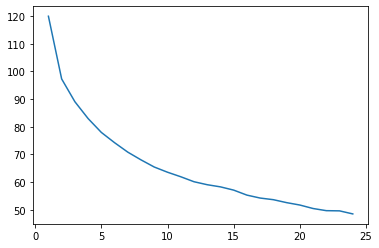

In [128]:
plt.plot(range(1,25),inertia)

In [129]:
kmeansffssd = cluster.KMeans(n_clusters=7)
kmeansffssd.fit(sd_ffs)
y_kmeans = kmeansffssd.predict(sd_ffs)

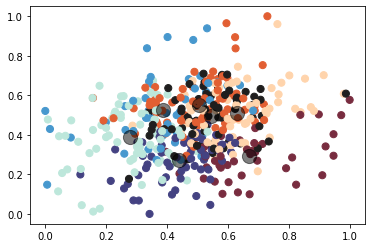

In [130]:
plt.scatter(sd_ffs.iloc[:, 0], sd_ffs.iloc[:, 1], c=y_kmeans, s=50, cmap='icefire')

centers = kmeansffssd.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

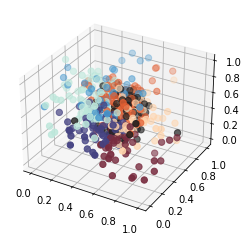

In [131]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(sd_ffs.iloc[:,0],sd_ffs.iloc[:,1],sd_ffs.iloc[:,2], c=y_kmeans, s=40, cmap='icefire')

## SD FFS KM NN

In [132]:
labels = kmeansffssd.labels_
labels

array([5, 6, 4, 0, 0, 0, 3, 3, 4, 4, 5, 4, 1, 5, 2, 1, 0, 3, 3, 1, 6, 6,
       4, 5, 6, 6, 0, 5, 5, 4, 0, 1, 4, 5, 5, 6, 6, 2, 6, 6, 4, 5, 6, 1,
       4, 2, 3, 0, 1, 5, 1, 6, 5, 3, 5, 0, 4, 5, 5, 4, 3, 5, 0, 3, 3, 6,
       5, 5, 0, 1, 4, 5, 5, 2, 1, 1, 2, 3, 3, 4, 4, 2, 2, 0, 1, 2, 5, 6,
       4, 5, 4, 1, 2, 5, 5, 1, 5, 0, 1, 3, 4, 5, 2, 2, 0, 4, 6, 2, 5, 5,
       2, 3, 6, 6, 2, 1, 6, 2, 4, 6, 4, 3, 5, 0, 5, 4, 4, 3, 6, 2, 5, 3,
       6, 2, 0, 3, 1, 4, 6, 1, 3, 4, 6, 2, 1, 3, 5, 6, 0, 3, 3, 3, 2, 4,
       1, 6, 4, 5, 5, 2, 0, 0, 5, 3, 3, 6, 5, 4, 5, 0, 6, 4, 3, 6, 2, 2,
       2, 3, 2, 1, 3, 1, 3, 2, 2, 2, 0, 4, 2, 0, 4, 6, 6, 4, 6, 2, 5, 2,
       3, 2, 1, 6, 3, 3, 5, 1, 2, 6, 2, 6, 3, 6, 5, 0, 5, 3, 5, 5, 3, 6,
       2, 2, 0, 3, 0, 2, 2, 0, 4, 3, 5, 3, 0, 6, 3, 5, 6, 5, 3, 0, 5, 2,
       1, 3, 1, 3, 1, 3, 6, 0, 5, 6, 1, 4, 0, 2, 6, 4, 5, 1, 3, 1, 6, 1,
       3, 3, 6, 5, 1, 1, 5, 0, 0, 5, 2, 6, 3, 5, 3, 0, 4, 1, 0, 6, 5, 0,
       6, 1, 0, 3, 5, 6, 3, 2, 0, 0, 0, 0, 3, 5, 1,

In [133]:
labelsdf = pd.DataFrame(labels, columns=["clusters"])
hot = OneHotEncoder().fit_transform(X = labelsdf).toarray()
labelsdf2 = pd.DataFrame(hot, columns= ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'])

In [134]:
sdffskmnn_df = pd.concat([sd_ffs.reset_index(),labelsdf2], axis=1)
sdffskmnn_df = sdffskmnn_df.drop('index',axis=1)
sdffskmnn_df

,home_elo,away_elo,spread,h_drives,h_d_explosiveness,h_d_stuffrate,h_o_explosiveness,h_o_successrate,h_o_stuffrate,h_o_totalPPA,C1,C2,C3,C4,C5,C6,C7
0,0.363287,0.560706,0.755814,0.545455,0.525943,0.189655,0.328233,0.530378,0.304348,0.467733,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.466974,0.458425,0.447674,0.454545,0.311295,0.295699,0.173752,0.677011,0.333333,0.487121,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.520737,0.178808,0.331395,0.363636,0.504999,0.545045,0.252425,0.599884,0.208333,0.490175,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.362519,0.406181,0.627907,0.090909,0.430090,0.329060,0.366020,0.433870,0.148148,0.267459,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.227343,0.507726,0.691860,0.272727,0.260224,0.333333,0.360928,0.414189,0.250000,0.233661,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,0.498464,0.345107,0.325581,0.272727,0.478934,0.392857,0.274292,0.558110,0.750000,0.420685,0.0,0.0,0.0,1.0,0.0,0.0,0.0
453,0.483103,0.403974,0.488372,0.272727,0.565888,0.458333,0.221948,0.617191,0.470588,0.280414,0.0,0.0,0.0,1.0,0.0,0.0,0.0
454,0.208909,0.397351,0.744186,0.363636,0.425106,0.134146,0.351512,0.410575,0.214286,0.323153,1.0,0.0,0.0,0.0,0.0,0.0,0.0
455,0.301075,0.306107,0.529070,0.545455,0.304514,0.396396,0.088698,0.547204,0.212766,0.291999,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
trainx, testx, trainy, testy = train_test_split(sdffskmnn_df, sd_target, test_size=.3, random_state=42)

In [136]:
sdffskmnn_df_nn = mlrose.NeuralNetwork(hidden_nodes = [6,6], activation = 'relu', algorithm = 'gradient_descent', max_iters = 5000, bias = True, is_classifier = True, learning_rate = 0.0001,
early_stopping = True, clip_max = 5, max_attempts = 1000, random_state = 3)

In [137]:
sdffskmnn_df_nn.fit(trainx,trainy)

NeuralNetwork(clip_max=5, early_stopping=True, hidden_nodes=[6, 6],
              learning_rate=0.0001, max_iters=5000)

In [138]:
y_train_pred = sdffskmnn_df_nn.predict(trainx)

y_train_accuracy = accuracy_score(trainy, y_train_pred)

print('Training accuracy: ', y_train_accuracy)

# Predict labels for test set and assess accuracy
y_test_pred = sdffskmnn_df_nn.predict(testx)

y_test_accuracy = accuracy_score(testy, y_test_pred)

print('Test accuracy: ', y_test_accuracy)

Training accuracy:  0.5862068965517241
Test accuracy:  0.5797101449275363


### SD FFS GMM

In [139]:
# ~ 30s 
gmm_bic = []
gmm_aic = []
for i in range(1,25):
    gmm = mixture.GaussianMixture(n_components=i, random_state=0).fit(sd_ffs)
    gmm_bic.append(gmm.bic(sd_ffs))
    gmm_aic.append(gmm.aic(sd_ffs))

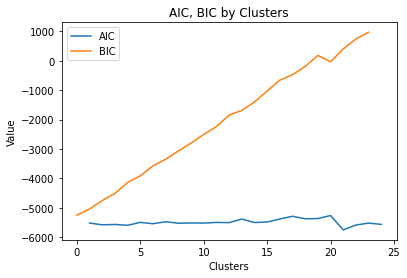

In [140]:
r = np.arange(1,25)
plt.plot(r, gmm_aic, gmm_bic)
plt.title("AIC, BIC by Clusters")
plt.xlabel('Clusters')
plt.ylabel('Value')
plt.legend(labels = ['AIC', 'BIC'])
plt.show()

In [141]:
# Even though AIC rises after 2, for comparison sake we will take AIC + BIC recommendation for simpler model and set K = 2 
gmm = mixture.GaussianMixture(n_components=4).fit(sd_ffs)
print(gmm.converged_)

True


In [142]:
labels = gmm.predict(sd_ffs)
len(labels)

457

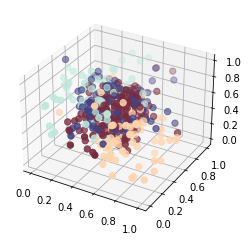

In [143]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(sd_ffs.iloc[:,0],sd_ffs.iloc[:,1],sd_ffs.iloc[:,2], c=labels, s=40, cmap='icefire')

In [144]:
labels.max()

3

In [145]:
labelsdf = pd.DataFrame(labels, columns=["clusters"])
hot = OneHotEncoder().fit_transform(X = labelsdf).toarray()
labelsdf2 = pd.DataFrame(hot, columns= ['C1', 'C2', 'C3', 'C4'])

In [146]:
sd_ffs_gmm_nn_df = pd.concat([sd_ffs.reset_index(),labelsdf2], axis=1)
sd_ffs_gmm_nn_df = sd_ffs_gmm_nn_df.drop('index',axis=1)
sd_ffs_gmm_nn_df

,home_elo,away_elo,spread,h_drives,h_d_explosiveness,h_d_stuffrate,h_o_explosiveness,h_o_successrate,h_o_stuffrate,h_o_totalPPA,C1,C2,C3,C4
0,0.363287,0.560706,0.755814,0.545455,0.525943,0.189655,0.328233,0.530378,0.304348,0.467733,0.0,1.0,0.0,0.0
1,0.466974,0.458425,0.447674,0.454545,0.311295,0.295699,0.173752,0.677011,0.333333,0.487121,0.0,0.0,1.0,0.0
2,0.520737,0.178808,0.331395,0.363636,0.504999,0.545045,0.252425,0.599884,0.208333,0.490175,0.0,0.0,0.0,1.0
3,0.362519,0.406181,0.627907,0.090909,0.430090,0.329060,0.366020,0.433870,0.148148,0.267459,1.0,0.0,0.0,0.0
4,0.227343,0.507726,0.691860,0.272727,0.260224,0.333333,0.360928,0.414189,0.250000,0.233661,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,0.498464,0.345107,0.325581,0.272727,0.478934,0.392857,0.274292,0.558110,0.750000,0.420685,0.0,0.0,1.0,0.0
453,0.483103,0.403974,0.488372,0.272727,0.565888,0.458333,0.221948,0.617191,0.470588,0.280414,0.0,0.0,1.0,0.0
454,0.208909,0.397351,0.744186,0.363636,0.425106,0.134146,0.351512,0.410575,0.214286,0.323153,0.0,1.0,0.0,0.0
455,0.301075,0.306107,0.529070,0.545455,0.304514,0.396396,0.088698,0.547204,0.212766,0.291999,0.0,0.0,1.0,0.0


In [147]:
trainx, testx, trainy, testy = train_test_split(sd_ffs_gmm_nn_df, sd_target, test_size=.3, random_state=42)

In [148]:
sd_ffs_gmm_nn = mlrose.NeuralNetwork(hidden_nodes = [6,6], activation = 'relu', algorithm = 'gradient_descent', max_iters = 5000, bias = True, is_classifier = True, learning_rate = 0.0001,
early_stopping = True, clip_max = 5, max_attempts = 1000, random_state = 3)

In [149]:
sd_ffs_gmm_nn.fit(trainx,trainy)

NeuralNetwork(clip_max=5, early_stopping=True, hidden_nodes=[6, 6],
              learning_rate=0.0001, max_iters=5000)

In [150]:
y_train_pred = sd_ffs_gmm_nn.predict(trainx)

y_train_accuracy = accuracy_score(trainy, y_train_pred)

print('Training accuracy: ', y_train_accuracy)

# Predict labels for test set and assess accuracy
y_test_pred = sd_ffs_gmm_nn.predict(testx)

y_test_accuracy = accuracy_score(testy, y_test_pred)

print('Test accuracy: ', y_test_accuracy)

Training accuracy:  0.6206896551724138
Test accuracy:  0.5434782608695652
